# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import plotly.express as px
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from tensorflow.keras.applications import DenseNet121
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D,Flatten, Dense, Dropout, BatchNormalization, Input, MaxPooling2D
from tensorflow.keras.utils import plot_model
from keras.callbacks import EarlyStopping


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Pulling images from Google drive and storing them in a dataframe with their classification label

In [ ]:
images_path = '/content/drive/My Drive/The IQ-OTHNCCD lung cancer dataset/Lung_Cancer_Dataset'

classes = ['Benign cases','Malignant cases','Normal cases']
images = {'Image Path': [], 'Label': []}

for class_type in classes:
  path = os.path.join(images_path,class_type)
  for image in os.listdir(path):
    images['Image Path'].append(os.path.join(path,image))
    images['Label'].append(class_type)

df = pd.DataFrame(images)
df

,Image Path,Label
0,/content/drive/My Drive/The IQ-OTHNCCD lung ca...,Benign cases
1,/content/drive/My Drive/The IQ-OTHNCCD lung ca...,Benign cases
2,/content/drive/My Drive/The IQ-OTHNCCD lung ca...,Benign cases
3,/content/drive/My Drive/The IQ-OTHNCCD lung ca...,Benign cases
4,/content/drive/My Drive/The IQ-OTHNCCD lung ca...,Benign cases
...,...,...
1092,/content/drive/My Drive/The IQ-OTHNCCD lung ca...,Normal cases
1093,/content/drive/My Drive/The IQ-OTHNCCD lung ca...,Normal cases
1094,/content/drive/My Drive/The IQ-OTHNCCD lung ca...,Normal cases
1095,/content/drive/My Drive/The IQ-OTHNCCD lung ca...,Normal cases


# Preliminary Data Analysis

Label
Malignant cases    561
Normal cases       416
Benign cases       120
Name: count, dtype: int64


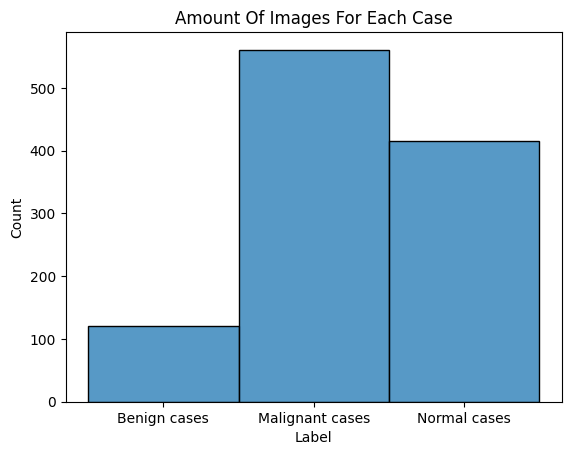

In [ ]:
print(df['Label'].value_counts())
sns.histplot(data=df, x = 'Label')
plt.title('Amount Of Images For Each Case')
plt.show()

In [ ]:
dimensions = []
count = 0
for path in df['Image Path']:
  image = cv2.imread(path)
  height,width = image.shape[:2]
  dimensions.append(str((height,width,df.iloc[count,1])))
  count += 1
dimensions_df = pd.DataFrame(dimensions)
dimensions_df.columns = ["Image Dimension"]
dimensions_df.value_counts()

Image Dimension              
(512, 512, 'Malignant cases')    501
(512, 512, 'Normal cases')       415
(512, 512, 'Benign cases')       120
(512, 623, 'Malignant cases')     31
(512, 801, 'Malignant cases')     28
(331, 506, 'Normal cases')         1
(404, 511, 'Malignant cases')      1
Name: count, dtype: int64

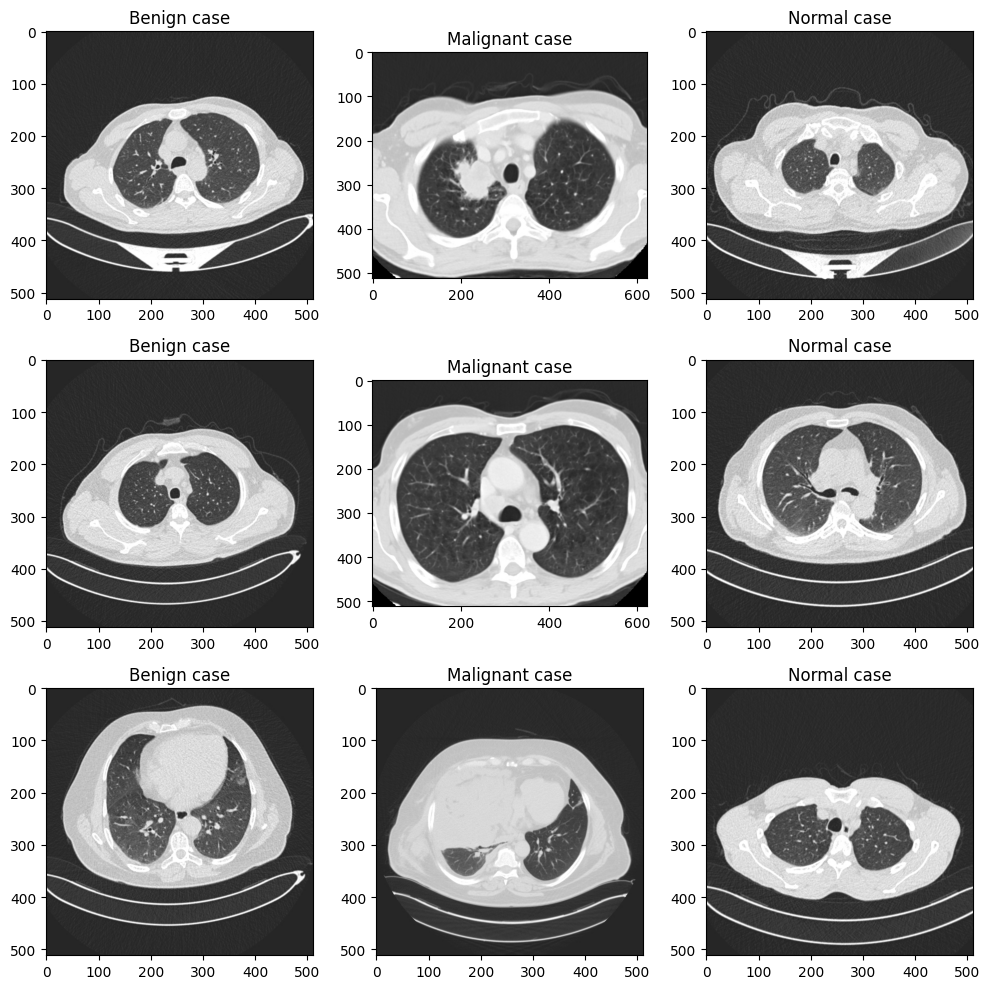

In [ ]:
fig, ax = plt.subplots(3,3, figsize = (10,10))
samples = df.groupby('Label').sample(n=3, random_state = 100)
count = 0
for i in range(3):
  for x in range(3):
    #print(count)
    image = cv2.imread(samples.iloc[count,0])
    ax[x,i].imshow(image)
    ax[x,i].set_title(classes[i][:-1])
    count += 1
#print(samples['Image Path'])

plt.tight_layout()

To reduce the computational load and having uniform size, I will reduce all the images to 256x256 to do so while keeping most of the information in tact from the images

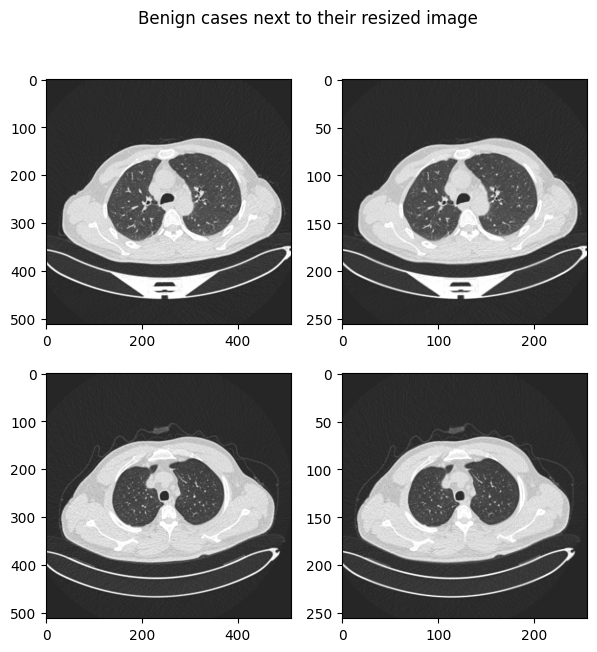

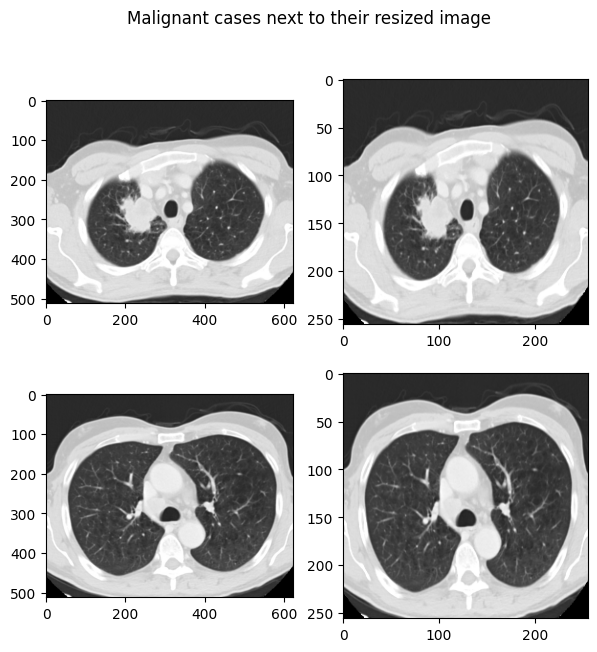

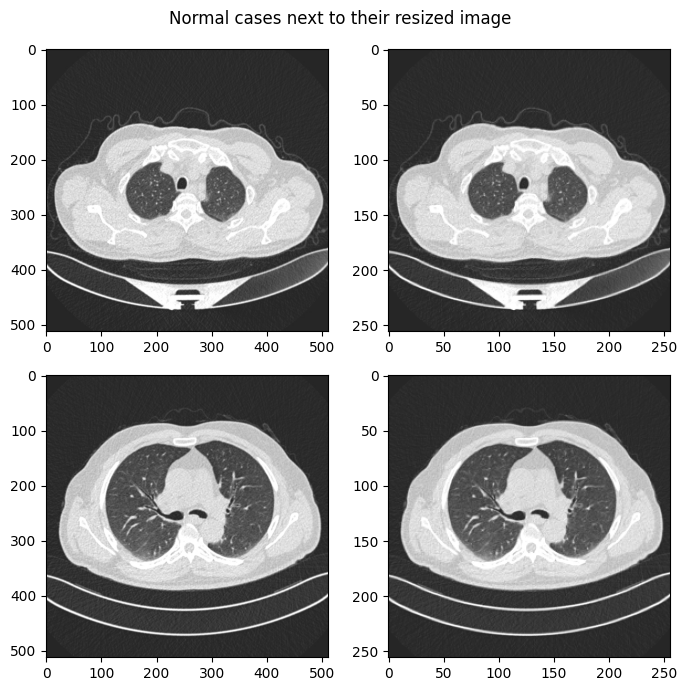

In [ ]:
samples_resize = df.groupby('Label').sample(n=2, random_state = 100)

for i in classes:
  fig, ax = plt.subplots(2,2, figsize = (7,7))
  paths = samples_resize[samples_resize['Label'] == i]
  for j in range(2):
    image = cv2.imread(paths.iloc[j,0])
    resized = cv2.resize(image,(256,256))
    fig.suptitle(i + " next to their resized image")
    ax[j,0].imshow(image)
    ax[j,1].imshow(resized)


plt.tight_layout()

# Splitting the Data into Train and Test sets

In [ ]:
traindf, testdf = train_test_split(df,test_size = .2,random_state = 100)
traindf

,Image Path,Label
687,/content/drive/My Drive/The IQ-OTHNCCD lung ca...,Normal cases
417,/content/drive/My Drive/The IQ-OTHNCCD lung ca...,Malignant cases
569,/content/drive/My Drive/The IQ-OTHNCCD lung ca...,Malignant cases
163,/content/drive/My Drive/The IQ-OTHNCCD lung ca...,Malignant cases
972,/content/drive/My Drive/The IQ-OTHNCCD lung ca...,Normal cases
...,...,...
802,/content/drive/My Drive/The IQ-OTHNCCD lung ca...,Normal cases
53,/content/drive/My Drive/The IQ-OTHNCCD lung ca...,Benign cases
350,/content/drive/My Drive/The IQ-OTHNCCD lung ca...,Malignant cases
79,/content/drive/My Drive/The IQ-OTHNCCD lung ca...,Benign cases


# Preparing Data and Data Augmentation Using Image Data Generator

Train and test generators normalize all pixel values to between 0 and 1 for easier computation, training generator randomly distorts images in different ways as shown in the parameters in ImageDataGenerator, the motivation behind doing so is it will allow the CNN model to better generalize the data and images by creating distortions and differences the model might see in unforeseen future images.

In [ ]:
train_generator = ImageDataGenerator(rescale = 1/255, zoom_range = .15, rotation_range = 10, height_shift_range=.2,width_shift_range=.1, shear_range = .1)

test_generator = ImageDataGenerator(rescale = 1/255)

train_images = train_generator.flow_from_dataframe(traindf, x_col = 'Image Path', y_col = 'Label', target_size = (256,256), color_mode = 'rgb', shuffle = True)

test_images = train_generator.flow_from_dataframe(testdf, x_col = 'Image Path', y_col = 'Label', target_size = (256,256), color_mode = 'rgb', shuffle = True)



Found 877 validated image filenames belonging to 3 classes.
Found 220 validated image filenames belonging to 3 classes.


Using DenseNet 121 Model as Feature Extractor for CNN model

Unlike a traditional CNN, DenseNet models have 'connectivity' between layers, layers aren't just connected to their previous layer, they are connected to all layers preceeding them. This leads to less parameters being needed and the model being computationally more efficient.

With the relatively small dataset being used for this project, using a pretrained model like DenseNet 121 as the feature extractor can help prevent overfitting since the model has already been trained on a much larger dataset(Imagenet) and can be adjusted and generalized to the specific dataset being used in this project.

In [ ]:
#Using the pre-trained DenseNet 121 model as a feature extractor, using it for feature maps(don't have to create layers for convolution and pooling operations)
#not final classification, will add layers to CNN model so it's tailored to this specific classification problem

base_densenet121 = DenseNet121(include_top = False, input_shape = (256,256,3), weights = 'imagenet')

#Setting include_top as false to add own layers and just use pre-trained model as a feature extractor/detector, to avoid overfitting, and using too many parameters and layers as well.

for layer in base_densenet121.layers:
  layer.trainable = False

29084464/29084464 [==============================] - 5s 0us/step


In [ ]:
DN121_model = Sequential()
DN121_model.add(Input(shape = (256, 256, 3)))  #Defining input structure of the data for the model

DN121_model.add(base_densenet121) #Adding the base model to act as a feature extractor

DN121_model.add(Flatten())  #Flatten the output from the base pre-trained model (DenseNet121) to a 1D vector into the layers of the CNN

DN121_model.add(Dense(512, activation = 'relu')) #creates neural network layer of 1024 neurons, relu helps the model to learn complex patterns by allowing image values to be non-linear

DN121_model.add(Dropout(.33)) #Will randomly set 20 percent of neurons to 0, this helps to prevent overfitting and let the model generalize the data better

DN121_model.add(Dense(3, activation = "softmax")) # Final layer will give output probabilites for each class given an image

DN121_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 8, 8, 1024)        7037504   
                                                                 
 flatten_1 (Flatten)         (None, 65536)             0         
                                                                 
 dense_3 (Dense)             (None, 512)               33554944  
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 40593987 (154.85 MB)
Trainable params: 33556483 (128.01 MB)
Non-trainable params: 7037504 (26.85 MB)
_________________________________________________________________


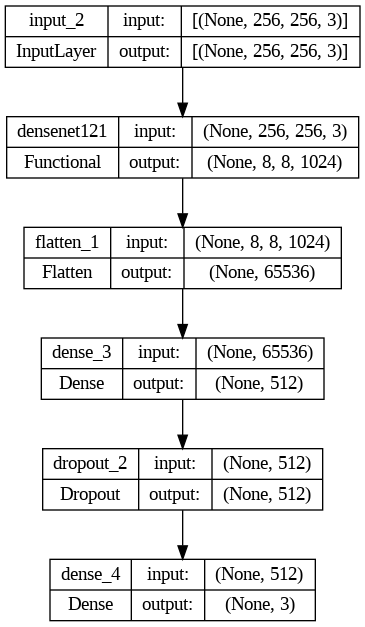

In [ ]:
DN121_model.compile(optimizer = 'adam', loss = "categorical_crossentropy", metrics = ["accuracy"])

#Visualizing the neural network
plot_model(DN121_model, show_shapes=True, show_layer_names=True)

In [ ]:
earlystopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#Helps prevent overfitting by making sure the model doesn't run more epochs than it needs to and makes the model save the best performing weights
#Setting monitoring criteria to validation/test loss since metric is associated with generalizability of model

history = DN121_model.fit(train_images, steps_per_epoch=len(train_images), epochs = 25,validation_data = test_images, validation_steps=len(test_images), callbacks=[earlystopping])

Epoch 1/25
28/28 [==============================] - 35s 1s/step - loss: 15.6310 - accuracy: 0.6773 - val_loss: 4.6016 - val_accuracy: 0.8318
Epoch 2/25
28/28 [==============================] - 25s 893ms/step - loss: 2.5100 - accuracy: 0.8244 - val_loss: 0.4835 - val_accuracy: 0.8773
Epoch 3/25
28/28 [==============================] - 30s 1s/step - loss: 0.7378 - accuracy: 0.8461 - val_loss: 0.3135 - val_accuracy: 0.8682
Epoch 4/25
28/28 [==============================] - 30s 1s/step - loss: 0.3392 - accuracy: 0.8734 - val_loss: 0.2557 - val_accuracy: 0.9045
Epoch 5/25
28/28 [==============================] - 25s 913ms/step - loss: 0.2842 - accuracy: 0.8837 - val_loss: 0.1977 - val_accuracy: 0.9364
Epoch 6/25
28/28 [==============================] - 25s 902ms/step - loss: 0.2742 - accuracy: 0.8951 - val_loss: 0.2187 - val_accuracy: 0.9000
Epoch 7/25
28/28 [==============================] - 27s 970ms/step - loss: 0.2835 - accuracy: 0.8848 - val_loss: 0.2068 - val_accuracy: 0.9045
Epoch 8

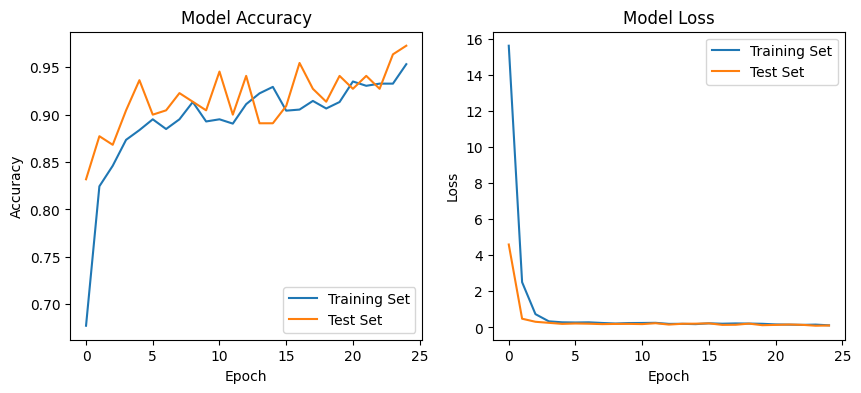

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (10,4) )
ax[0].plot(history.history['accuracy'], label='Training Set')
ax[0].plot(history.history['val_accuracy'], label='Test Set')

ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(history.history['loss'], label='Training Set')
ax[1].plot(history.history['val_loss'], label='Test Set')

ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()


# Experimenting With Class Weights

As shown before building our first model, there is a big imbalance between the amounts of images for each classification in the dataset. So I'm now experimenting to see if using class weights for each classifcation will improve model performance.

In [ ]:
#Calculating class weights

weights = class_weight.compute_class_weight(class_weight='balanced',classes = np.unique(train_images.classes), y = train_images.classes)
print(weights) #Formatted in benign,malignant, normal
weights_dict = {}
for i in range(3):
  weights_dict[i] = weights[i]
weights_dict



[3.10992908 0.65840841 0.86234022]


{0: 3.1099290780141846, 1: 0.6584084084084084, 2: 0.8623402163225172}

In [ ]:
weights_history = DN121_model.fit(train_images, steps_per_epoch=len(train_images), epochs = 25,validation_data = test_images, validation_steps=len(test_images), callbacks=[earlystopping],
                                  class_weight = weights_dict)

Epoch 1/25
28/28 [==============================] - 40s 1s/step - loss: 23.8767 - accuracy: 0.5325 - val_loss: 2.4941 - val_accuracy: 0.8000
Epoch 2/25
28/28 [==============================] - 25s 909ms/step - loss: 3.6554 - accuracy: 0.7583 - val_loss: 1.5818 - val_accuracy: 0.7273
Epoch 3/25
28/28 [==============================] - 24s 876ms/step - loss: 0.9808 - accuracy: 0.8130 - val_loss: 0.4304 - val_accuracy: 0.8136
Epoch 4/25
28/28 [==============================] - 24s 863ms/step - loss: 0.7242 - accuracy: 0.8050 - val_loss: 0.2908 - val_accuracy: 0.8682
Epoch 5/25
28/28 [==============================] - 28s 995ms/step - loss: 0.4114 - accuracy: 0.8449 - val_loss: 0.2572 - val_accuracy: 0.8636
Epoch 6/25
28/28 [==============================] - 26s 927ms/step - loss: 0.3742 - accuracy: 0.8746 - val_loss: 0.2004 - val_accuracy: 0.9273
Epoch 7/25
28/28 [==============================] - 25s 900ms/step - loss: 0.4652 - accuracy: 0.8335 - val_loss: 0.2058 - val_accuracy: 0.9182
E

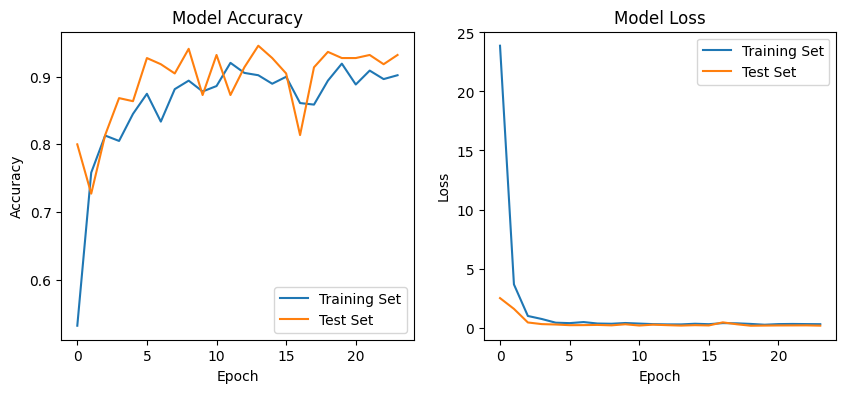

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (10,4) )
ax[0].plot(weights_history.history['accuracy'], label='Training Set')
ax[0].plot(weights_history.history['val_accuracy'], label='Test Set')

ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(weights_history.history['loss'], label='Training Set')
ax[1].plot(weights_history.history['val_loss'], label='Test Set')

ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()

# Custom Made CNN

Now experimenting and testing out making my own CNN model from scratch and seeing if I can improve upon the performance of the DenseNet models. I wasn't able to achieve the same accuracy and validation loss metrics as the previous models, but through experimentation and tuning the model I was able to raise the final model accuracy from 45-50% the first time I ran the model, to an accuracy of 70-75%.

As discussed before, it's normally better to use a pretrained model for the feature extracting layers for a relatively smaller dataset due to the issue of overfitting which is evident when creating a custom CNN from scratch without using the transfer learning of a model like the DenseNet model.

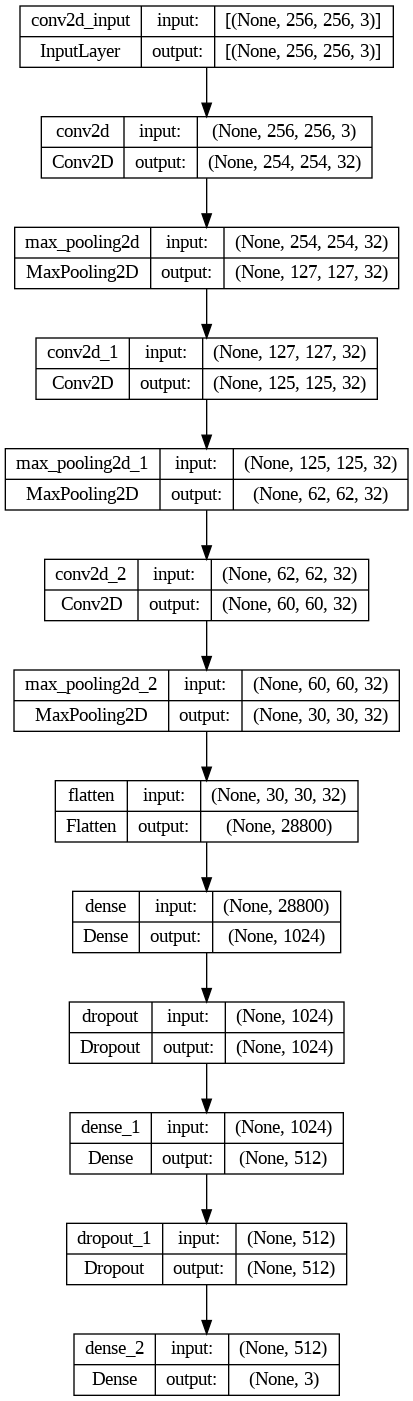

In [2]:
custom_model = Sequential()

custom_model.add(Conv2D (32, (3, 3), input_shape = (256, 256,3), activation = 'relu')) #Creates convolutional layer with 32 filters acting as feature detectors
                                                                                        #Using lower amounts of filters appeared to be less effective and accurate when running the model
custom_model.add(MaxPooling2D(pool_size=(2, 2))) #Using pooling layer to reduce dimensions of image for next layer

custom_model.add(Conv2D(32, (3, 3), activation='relu')) #Repeating same layers but these layers work on dimension-reduced, simpler images

custom_model.add(MaxPooling2D(pool_size=(2, 2)))

custom_model.add(Conv2D(32, (3, 3), activation='relu'))

custom_model.add(MaxPooling2D(pool_size=(2, 2)))
custom_model.add(Flatten()) #Flattening converts the 2D feature maps created by the layers above into a 1D vector that can be taken in by the dense layer of neurons

custom_model.add(Dense(1024)) #Creates dense layer of 1024 neurons which are tasked to learn the combinations and patterns from the feature maps created by the previous layers
custom_model.add(Dropout(.5)) #Randomly setting half the neurons to 0 to prevent overfitting by making sure the network doesn't single handedly rely on a couple neurons
custom_model.add(Dense(512))
custom_model.add(Dropout(.25))
custom_model.add(Dense(3, activation='softmax')) #Creates neuron for each class and outputs probability a given image is in each class

custom_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
plot_model(custom_model, show_shapes=True, show_layer_names=True)

In [ ]:
earlystopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = custom_model.fit(train_images, steps_per_epoch=len(train_images), epochs = 25,batch_size = 32,validation_data = test_images, validation_steps=len(test_images), callbacks=[earlystopping])

Epoch 1/25
28/28 [==============================] - 219s 8s/step - loss: 2.0667 - accuracy: 0.4823 - val_loss: 0.9664 - val_accuracy: 0.5091
Epoch 2/25
28/28 [==============================] - 25s 890ms/step - loss: 0.9457 - accuracy: 0.5051 - val_loss: 0.9167 - val_accuracy: 0.5227
Epoch 3/25
28/28 [==============================] - 23s 821ms/step - loss: 0.9280 - accuracy: 0.5211 - val_loss: 0.9201 - val_accuracy: 0.5318
Epoch 4/25
28/28 [==============================] - 24s 867ms/step - loss: 0.9177 - accuracy: 0.5211 - val_loss: 0.9205 - val_accuracy: 0.5182
Epoch 5/25
28/28 [==============================] - 25s 875ms/step - loss: 0.8925 - accuracy: 0.5382 - val_loss: 1.1022 - val_accuracy: 0.5318
Epoch 6/25
28/28 [==============================] - 24s 865ms/step - loss: 0.8901 - accuracy: 0.5770 - val_loss: 0.8486 - val_accuracy: 0.5955
Epoch 7/25
28/28 [==============================] - 24s 830ms/step - loss: 0.8912 - accuracy: 0.5621 - val_loss: 0.8848 - val_accuracy: 0.5727
E

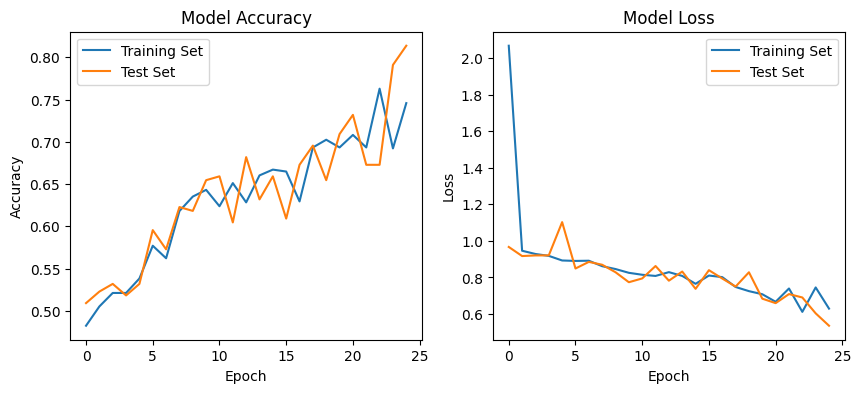

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (10,4) )
ax[0].plot(history.history['accuracy'], label='Training Set')
ax[0].plot(history.history['val_accuracy'], label='Test Set')

ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(history.history['loss'], label='Training Set')
ax[1].plot(history.history['val_loss'], label='Test Set')

ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()

# Conclusion

Using the DenseNet 121(with 121 representing the amount of layers) pre-trained model as the feature extractor garnered an accuracy on the test data roughly around 95% and an accuracy around 91-93% using class weights. The custom CNN model didn't perform as well but through experimentation, adding new layers, and tuning the model I was able to raise the accuracy on the test dataset to around 70-75% from around 45-50% when I first ran the model.

The findings from this project kind of reinforce the idea of using a transfer learning model as the feature extractor for a CNN model when you are dealing with a relatively small dataset. DenseNet and other transfer models are trained on huge datasets which perform well at generalizing and adjusting to smaller datasets like the one used in this project. Using these transfer learning models as the feature extractors for an image recognition task that utilizes a small dataset helps preventing overfitting, as that became an issue with the custom CNN I made with custom feature extracting layers.